In [28]:
import qiskit
from qiskit import *
import pylatexenc
from qiskit_aer import AerSimulator
import numpy as np
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
#import qiskit.tools.jupyter
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer.noise import NoiseModel
from qiskit_ibm_runtime.fake_provider import FakeAthensV2, FakeKyiv, FakeKyoto
from qiskit.quantum_info import Statevector

In [29]:
sim = AerSimulator()

In [30]:
class Circuit():
    def run(self, qc, sim, shots=1024, memory=False):
        '''
        This function takes a circuit and simulator as input, compiles the circuit, runs the simulator and then plots the results.
        '''
        compiled_circuit = transpile(qc, sim)
        sim_result = sim.run(compiled_circuit, shots=shots, memory=memory).result() #default shots=1024
        return sim_result
    def display(self, sim_result):
        res = sim_result.get_counts()
        return plot_histogram(res)

In [31]:
circ = Circuit()

 ## Part 1:Implementation of Iterative Phase Estimation algorithm

### 1. Understand a circuit with non-unitary operations.

#### &#128211;Step B. Complete the rest of the circuit so that the auxiliary qubit ( top qubit ) after the reset would be in the state $\frac{1}{\sqrt2}(|0\rangle + e^{-i\frac{\pi}{2}}|1\rangle)$ if the value of the classical bit is one or remains zero state otherwise.

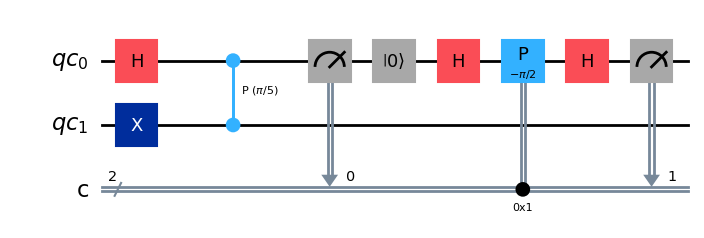

In [32]:
q = QuantumRegister(2, name="qc")
c = ClassicalRegister(2,  name="c")

qc1 = QuantumCircuit(q,c)
qc1.h(q[0])
qc1.x(q[1])
qc1.cp(np.pi/5, q[0], q[1])
qc1.measure(q[0], c[0])
qc1.reset(q[0])

###### your code goes here #####

qc1.h(q[0])
qc1.p(-np.pi/2, q[0]).c_if(c,1)

##########################
qc1.h(q[0])
qc1.measure(q[0],c[1])

qc1.draw(output="mpl")

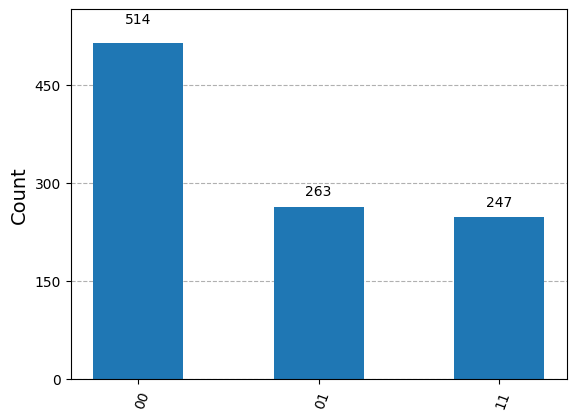

In [33]:
circ.display(circ.run(qc1, sim))

### 3. Estimate the phase of the $T$-gate implementing IPE algorithm.

#### &#128211;Step A. Obtain the least significant phase bit of the $T$-gate by setting up the circuit <code>T_x3</code> properly and assign the value to the variable <code>x_3</code>.

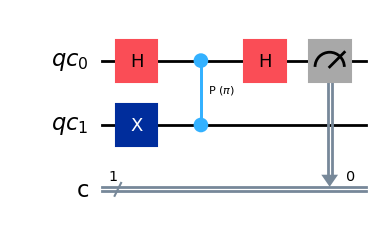

In [34]:
q = QuantumRegister(2, name="qc")
c = ClassicalRegister(1, name="c")

T_x3 = QuantumCircuit(q,c)

########## your code goes here #######

##1 Initialization

T_x3.h(q[0])
T_x3.x(q[1])

##2 Apply control-U operator as many times as needed to get the least significant phase bit

t_angle = np.pi/4
k=2
cphase_angle = t_angle * 2**k
T_x3.cp(cphase_angle, q[0], q[1])

##3 measure the anscillar qubit in x-basis

T_x3.h(q[0])
T_x3.measure(q[0], c[0])

T_x3.draw("mpl")

In [35]:
########## Simulate the circuit and assign the output value to the variable 'x_3'
job = circ.run(T_x3, sim, shots=1, memory=True)
x_3 = int(job.get_memory()[0])
print(x_3)

1


#### &#128211;Step B. Extract the middle phase bit of the $T$-gate by creating the circuit <code>T_x2</code> with phase correction using <code>x_3</code> value from Step A. Assign the outcome bit to the variable <code>x_2</code>.

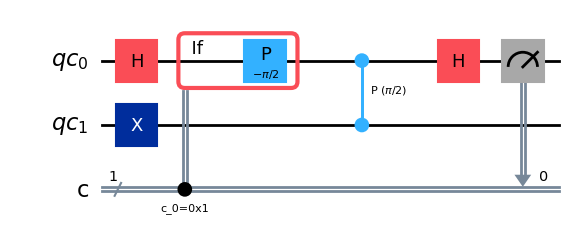

In [36]:
q = QuantumRegister(2, name="qc")
c = ClassicalRegister(1, name="c")

T_x2 = QuantumCircuit(q,c)

########### your code goes here ##########

##1 Initialization

T_x2.h(q[0])
T_x2.x(q[1])

##2 phase correction

with T_x2.if_test((c[0], x_3)):
    T_x2.p(-np.pi / 2, q[0])

##3 Apply control-U operator as many times as needed

t_angle = np.pi/4
k=1
cphase_angle = t_angle * 2**k
T_x2.cp(cphase_angle, q[0], q[1])

##4 measure the anscillar qubit in x-basis

T_x2.h(q[0])
T_x2.measure(q[0], c[0])

T_x2.draw("mpl")

In [49]:
######## Simulate the circuit and assign the output value to the variable 'x_2'
job = circ.run(T_x2, sim, shots=1, memory=True)
x_2 = int(job.get_memory()[0])
print(x_2)

0


#### &#128211;Step C. Find the most significant phase bit of the $T$-gate and assign it to the variable <code>x_1</code>. 

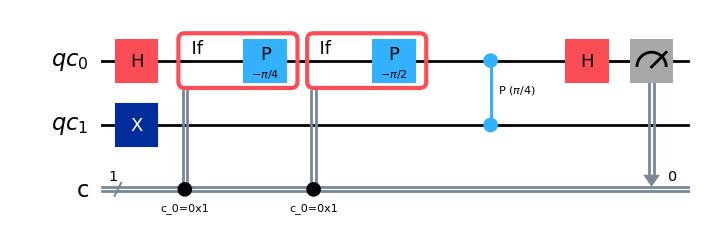

In [11]:
q = QuantumRegister(2, name="qc")
c = ClassicalRegister(1,name="c")

T_x1 = QuantumCircuit(q,c)

########### your code goes here #########

##1 Initialization

T_x1.h(q[0])
T_x1.x(q[1])

##2 phase correction

with T_x1.if_test((c[0], x_3)):
     T_x1.p(-np.pi / 4, q[0])
with T_x1.if_test((c[0], x_2)):
     T_x1.p(-np.pi / 2, q[0])

##3 Apply control-U operator as many times as needed to get the least significant phase bit

t_angle = np.pi/4
k=0
cphase_angle = t_angle * 2**k
T_x1.cp(cphase_angle, q[0], q[1])

##4 measure the anscillar qubit in x-basis

T_x1.h(q[0])
T_x1.measure(q[0], c[0])

T_x1.draw("mpl")

In [40]:
########## Simulate the circuit and assign the output value to the variable 'x_1'
job = circ.run(T_x1, sim, shots=1, memory=True)
x_1 = int(job.get_memory()[0])
print(x_1)

0


In [41]:
T_phase_bits = '{}{}{}'.format(x_1, x_2, x_3)
T_phase_bits == '001'

True

#### &#128211;Step D. Construct the full IPE circuit and pass it to the variable <code>qc_T</code> ; Put the all steps that you performed into one circuit utilizing conditional operations and reset. 

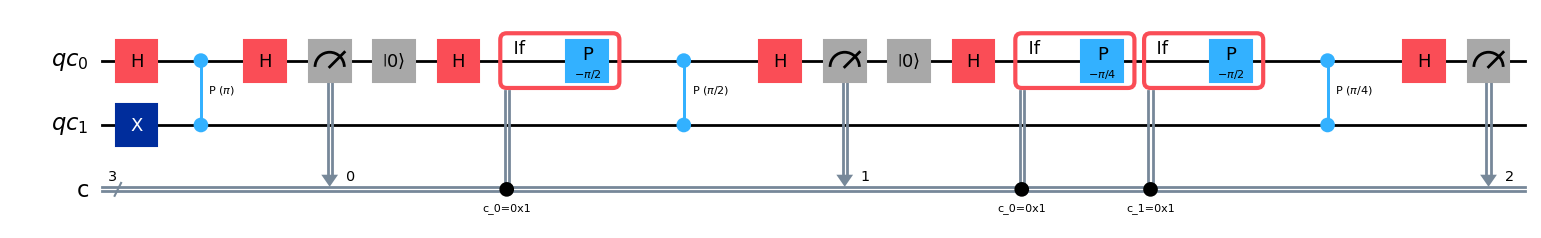

In [14]:
##### your code goes here ######
q = QuantumRegister(2, name="qc")
c = ClassicalRegister(3,name="c")

qc_T = QuantumCircuit(q,c)

qc_T.h(q[0])
qc_T.x(q[1])

t_angle = np.pi / 4
k = 2
cphase_angle = t_angle * 2**k
qc_T.cp(cphase_angle, q[0], q[1])

qc_T.h(q[0])
qc_T.measure(q[0], c[0])

qc_T.reset(q[0])
qc_T.h(q[0])

with qc_T.if_test((c[0], 1)):
    qc_T.p(-np.pi / 2, q[0])

k = 1
cphase_angle = t_angle * 2**k
qc_T.cp(cphase_angle, q[0], q[1])

qc_T.h(q[0])
qc_T.measure(q[0], c[1])

qc_T.reset(q[0])
qc_T.h(q[0])

with qc_T.if_test((c[0], 1)):
    qc_T.p(-np.pi / 4, q[0])
with qc_T.if_test((c[1], 1)):
    qc_T.p(-np.pi / 2, q[0])

k = 0
cphase_angle = t_angle * 2**k
qc_T.cp(cphase_angle, q[0], q[1])

qc_T.h(q[0])
qc_T.measure(q[0], c[2])

################
qc_T.draw("mpl")

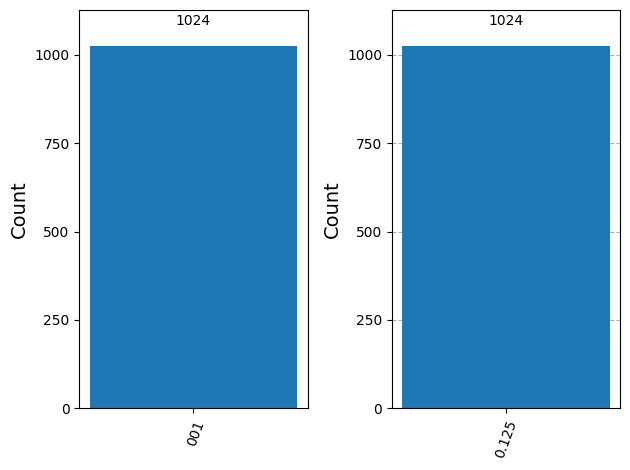

In [15]:
count0 = circ.run(qc_T, sim).get_counts()
n=3
key_new = [str(int(key,2)/2**n) for key in list(count0.keys())]
count1 = dict(zip(key_new, count0.values()))

fig, ax = plt.subplots(1,2)
plot_histogram(count0, ax=ax[0])
plot_histogram(count1, ax=ax[1])
plt.tight_layout()

#### &#128211;Step A. How many classical registers is needed? Assign the value to the variable <code>n</code>.  

In [16]:
## your answer goes here
n = 4

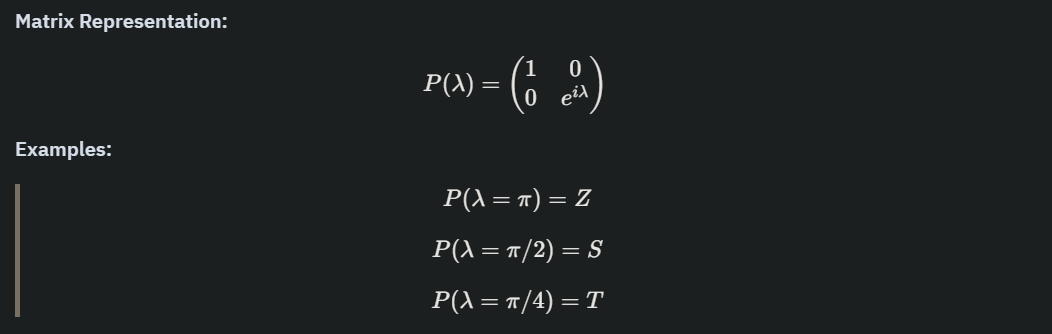

#### &#128211;Step B. Construct the IPE circuit in the following cell. 

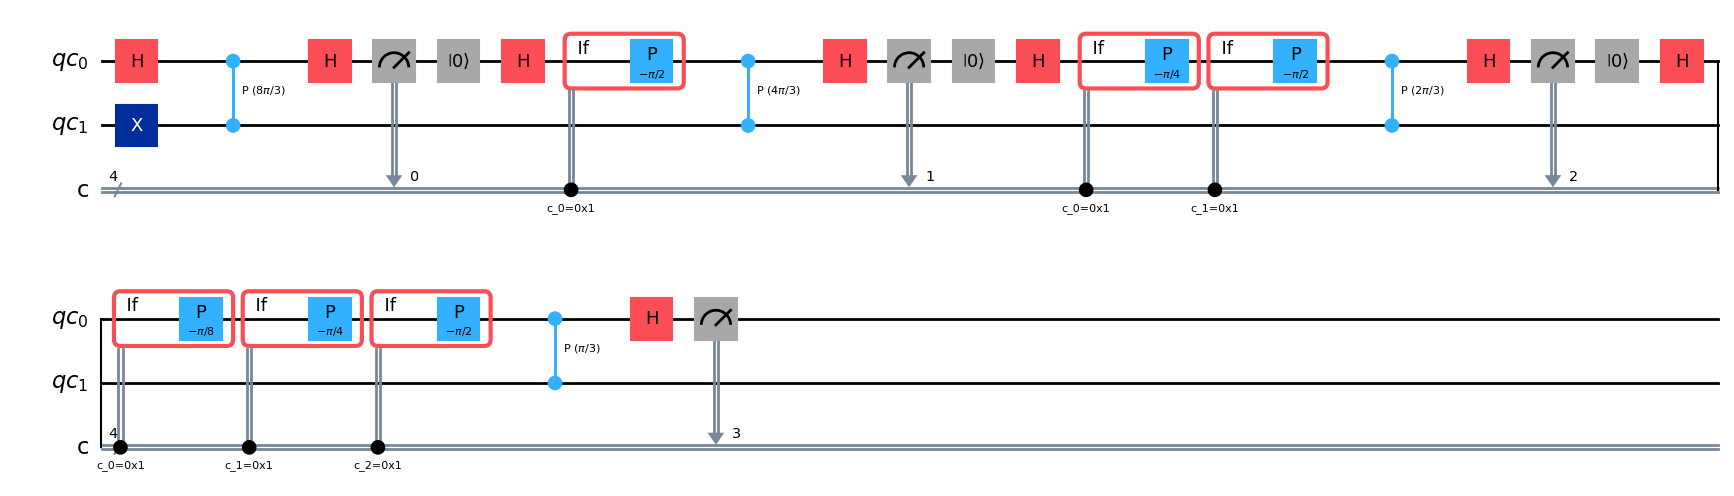

In [17]:
q = QuantumRegister(2, name="qc")
c = ClassicalRegister(n, name="c")

IPE = QuantumCircuit(q,c)

########## your code goes here ############

IPE.h(q[0])
IPE.x(q[1])

p_angle = np.pi / 3
k = 3
cphase_angle = p_angle * 2**k
IPE.cp(cphase_angle, q[0], q[1])

IPE.h(q[0])
IPE.measure(q[0], c[0])

IPE.reset(q[0])
IPE.h(q[0])

with IPE.if_test((c[0], 1)):
    IPE.p(-np.pi / 2, q[0])

k = 2
cphase_angle = p_angle * 2**k
IPE.cp(cphase_angle, q[0], q[1])

IPE.h(q[0])
IPE.measure(q[0], c[1])

IPE.reset(q[0])
IPE.h(q[0])

with IPE.if_test((c[0], 1)):
    IPE.p(-np.pi / 4, q[0])
with IPE.if_test((c[1], 1)):
    IPE.p(-np.pi / 2, q[0])

k = 1
cphase_angle = p_angle * 2**k
IPE.cp(cphase_angle, q[0], q[1])

IPE.h(q[0])
IPE.measure(q[0], c[2])

IPE.reset(q[0])
IPE.h(q[0])

with IPE.if_test((c[0], 1)):
    IPE.p(-np.pi / 8, q[0])
with IPE.if_test((c[1], 1)):
    IPE.p(-np.pi / 4, q[0])
with IPE.if_test((c[2], 1)):
    IPE.p(-np.pi / 2, q[0])

k = 0
cphase_angle = p_angle * 2**k
IPE.cp(cphase_angle, q[0], q[1])

IPE.h(q[0])
IPE.measure(q[0], c[3])
#####################
IPE.draw("mpl")

#### Step C. Run the cell below to create the QPE circuit for the comparison. 

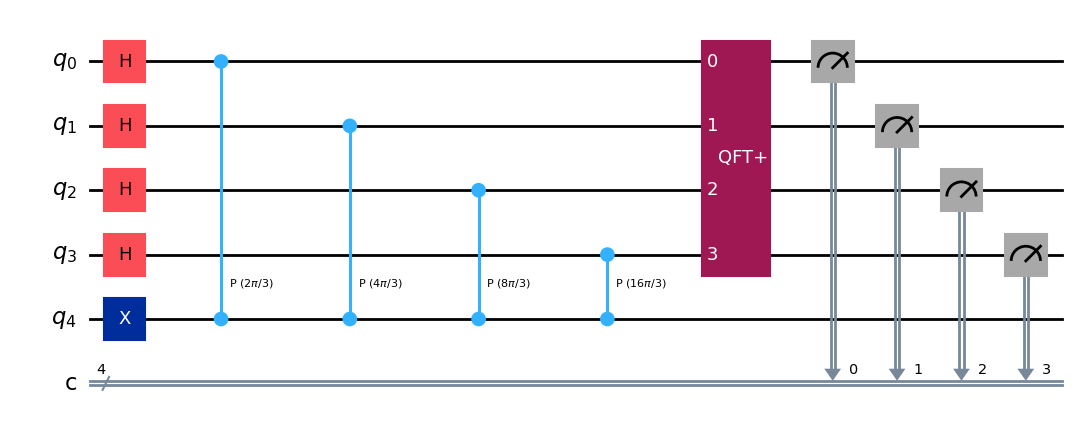

In [18]:
def qft(n):
    """Creates an n-qubit QFT circuit"""
    circuit = QuantumCircuit(n)
    def swap_registers(circuit, n):
        for qubit in range(n//2):
            circuit.swap(qubit, n-qubit-1)
        return circuit
    def qft_rotations(circuit, n):
        """Performs qft on the first n qubits in circuit (without swaps)"""
        if n == 0:
            return circuit
        n -= 1
        circuit.h(n)
        for qubit in range(n):
            circuit.cp(np.pi/2**(n-qubit), qubit, n)
        qft_rotations(circuit, n)

    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit


# define the parameters
t, psi = 4, 1/3*np.pi*2

# building a circuit
QPE = QuantumCircuit(t+1,t)
QPE.h(range(t))
QPE.x(t)
for idx in range(t):
    QPE.cp(psi*2**idx, idx, t)

qft_dag = qft(t).to_gate().inverse()
qft_dag.label = 'QFT+'
QPE.append(qft_dag, range(t))
QPE.measure(range(t), range(t))

QPE.draw("mpl")

### Transpile the IPE circuit

In [19]:
# QiskitRuntimeService.save_account(channel="ibm_quantum", token="dfafbcbd3d49a75961ff8ff8c7dcc565c536954b87b224afe5294631389e5dc6e32362b0ea5d2747c3f671a3d0ca84b40d6126b88b5446c40adf218ba44cccd9")

In [20]:
# service = QiskitRuntimeService()
# backend = service.backend("ibm_kyiv")

# service = QiskitRuntimeService(instance='ibm-q/open/main')
# backend = service.backend("fake_kyiv")
# print("OK ✅")

backend = FakeKyoto()

In [21]:
######## your code to transpile IPE circuit goes here ########

num = 500
IPE_trans = transpile([IPE]*num, backend, optimization_level=3)
IPE_trans_depth = np.array([IPE_trans[idx].depth() for idx in range(num)])

#####################
print("OK ✅")

OK ✅


In [22]:
print(IPE_trans_depth.max(), IPE_trans_depth.min())

65 63


In [23]:
num = 500
QPE_trans = transpile([QPE]*num, backend, optimization_level=3)
QPE_trans_depth = np.array([QPE_trans[idx].depth() for idx in range(num)])
print(min(QPE_trans_depth), max(QPE_trans_depth))
best_arg = np.argmin(QPE_trans_depth)
QPE_trans_best = QPE_trans[best_arg]
print("OK ✅")

106 139
OK ✅


In [24]:
shots=20000
noise_model = NoiseModel.from_backend(backend)
counts=[-1, -1]

In [25]:
counts[0] = sim.run(IPE_trans, noise_model=noise_model).result().get_counts()
counts[1] = sim.run(QPE_trans_best, noise_model=noise_model).result().get_counts()
print("OK ✅")

OK ✅


In [26]:
QPE_exact = QuantumCircuit(t+1)
QPE_exact.h(range(t))
QPE_exact.x(t)
for idx in range(t):
    QPE_exact.cp(psi*2**idx, idx, t)

qft_dag = qft(t).to_gate().inverse()
qft_dag.label = 'QFT+'
QPE_exact.append(qft_dag, range(t))

#QPE_exact.draw('mpl')

state = Statevector.from_instruction(QPE_exact)
pmf = state.probabilities_dict(range(4))

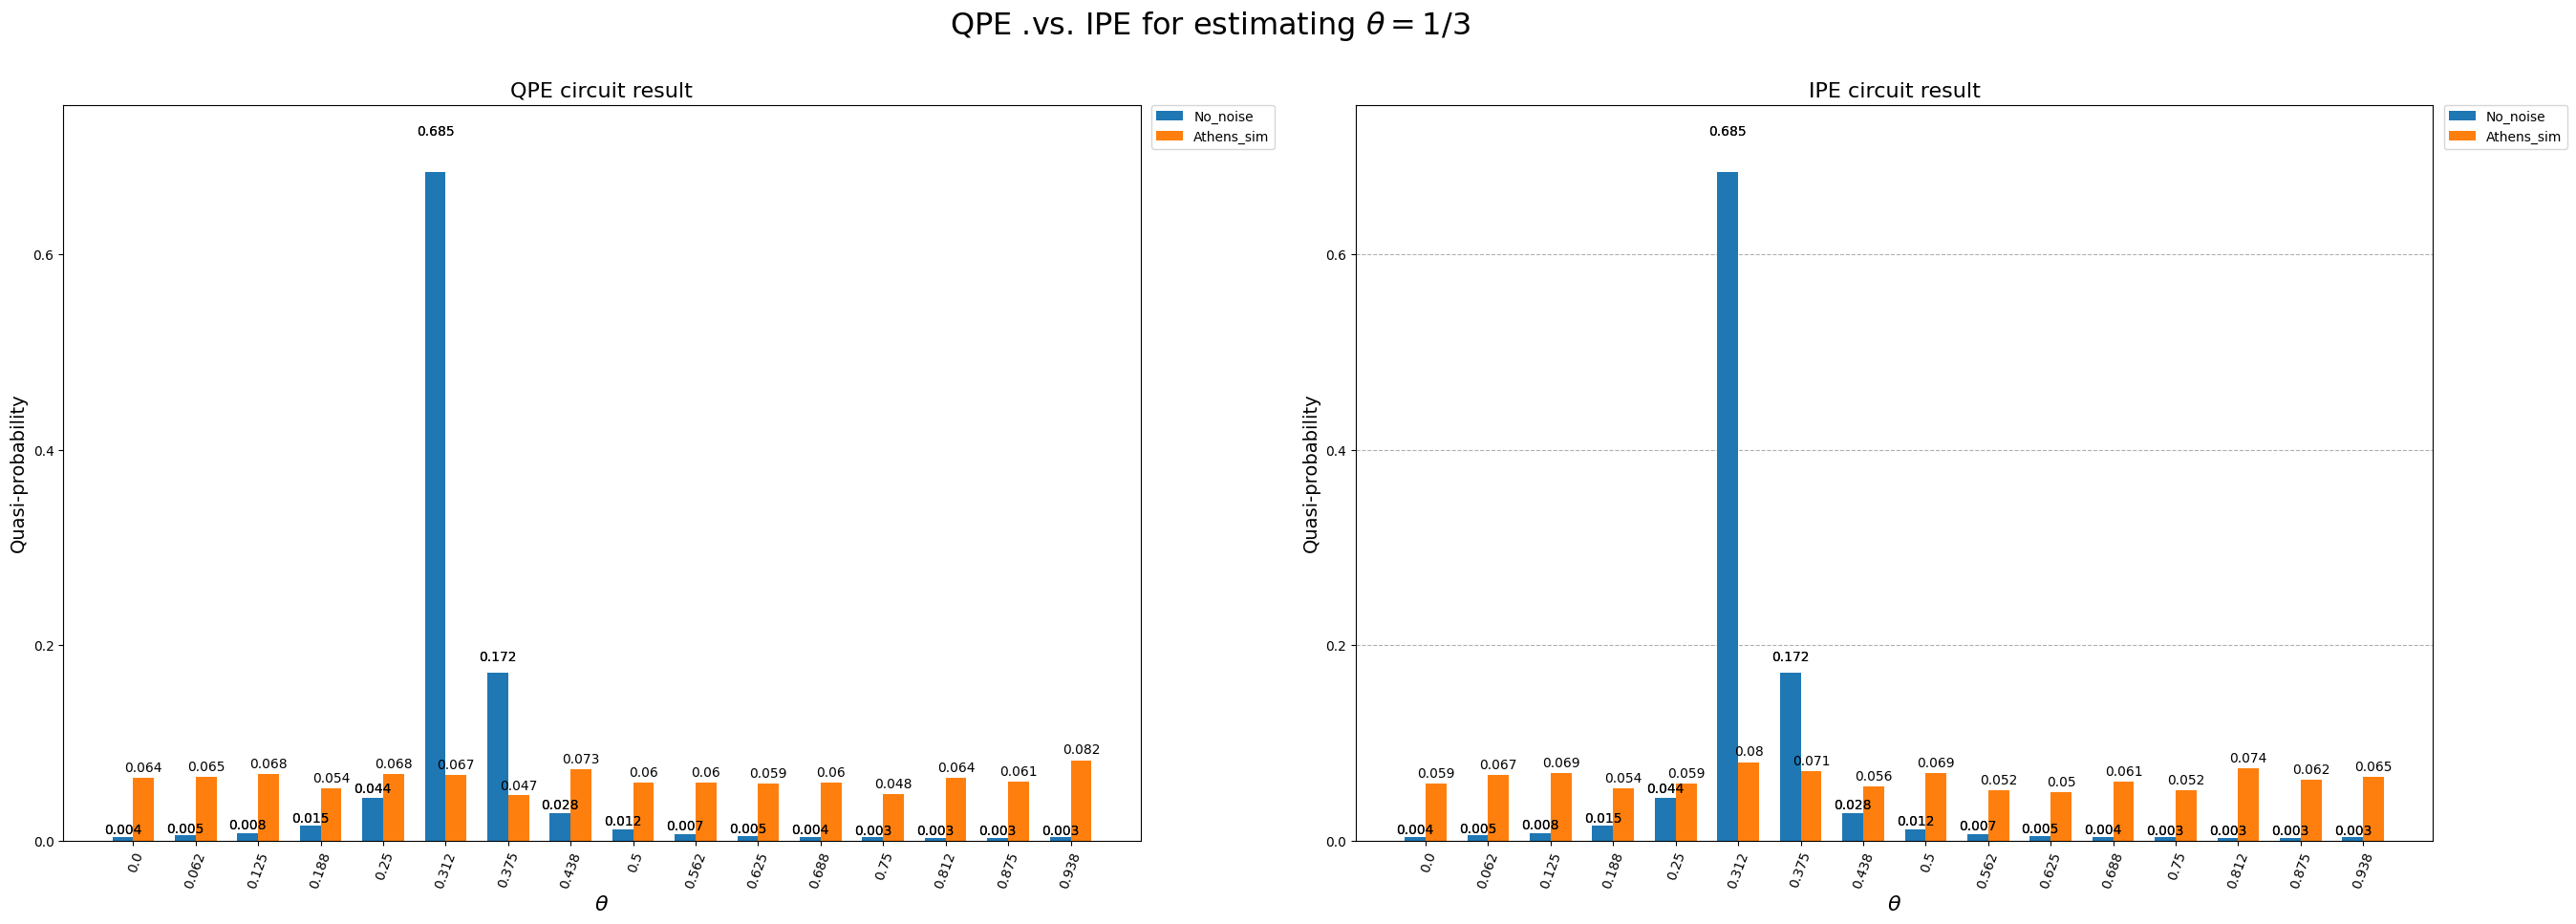

In [27]:
def count_new(count):
    phi_est = np.array([round(int(key, 2)/2**t, 3) for key in list(count.keys())])
    key_new = list(map(str, phi_est))
    count_new = dict(zip(key_new, count.values()))
    return count_new

pmf_new = count_new(pmf)
count_IPE = count_new(counts[0][499])
count_QPE = count_new(counts[1])

fig, ax = plt.subplots(1, 2, figsize=(32,10))
fig.suptitle('QPE .vs. IPE for estimating $\\theta=1/3$', fontsize=23)
plot_histogram([pmf_new, count_QPE], ax=ax[0], legend=['No_noise', 'Athens_sim'])
plot_histogram([pmf_new, count_IPE], ax=ax[1], legend=['No_noise', 'Athens_sim'])
ax[0].set_title('QPE circuit result', fontsize=16)
ax[0].set_xlabel('$\\theta$', fontsize=16)
ax[1].set_title('IPE circuit result', fontsize=16)
ax[1].set_xlabel('$\\theta$', fontsize=16)
plt.show()

#### &#128211;Step G. Discuss about the results.

We see that without noise there is no appreciable difference in the probability of the search algorithms while in the presence of noise IPE performs better than QPE (0.08> 0.067) on the most probable phase (θ=0.312), though both algorithms see a significant perfomance drop in presence of Noise.